# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

__Описание данных__

Данные геологоразведки трёх регионов находятся в файлах: 
 - /datasets/geo_data_0.csv
 - /datasets/geo_data_1.csv
 - /datasets/geo_data_2.csv


 - `id` — уникальный идентификатор скважины;
 - `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
 - `product` — объём запасов в скважине (тыс. баррелей).

__Условия задачи:__
 - Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
 - При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
 - Бюджет на разработку скважин в регионе — 10 млрд рублей.
 - При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
 - После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

%matplotlib inline

RANDOM_STATE = 732568

## Загрузка и подготовка данных

### Загрузка и общая информация

In [2]:
def load_dataset(dataset_name):
    return pd.read_csv('/datasets/' + dataset_name)

In [3]:
def general_info(df: pd.core.frame.DataFrame):
    rows_number = 5
    subdataframe_length = 10000
    
    separator_symbols_count = 100
    
    print(f'Первые {rows_number} строк датасета')
    display(df.head(rows_number))
    print('='*separator_symbols_count, '\n')
    print('Общая информация о признаках')
    print()
    df.info()
    print('='*separator_symbols_count, '\n')
    print('Количество признаков, которые имеют пропущенные значения:', df.isna().any().sum())
    print()
    print('Доля признаков, которые имеют пропущенные значения',
          round(df.isna().any().sum() / df.shape[1], 2))
    print()
    print('='*separator_symbols_count, '\n')
    print('Количество явных дубликатов:', df.duplicated().sum())
    print()
    print('='*separator_symbols_count, '\n')
    print('Описательные статистики признаков')
    display(df.describe().round(2))
    print('='*separator_symbols_count, '\n')
    print('Коэффициенты корреляции признаков')
    display(df.corr().style.background_gradient().set_precision(2))
    print('='*separator_symbols_count, '\n')
    print('Гистограммы и парные диаграммы рассеивания')
    sns.pairplot(
        df.sample(n=subdataframe_length),
        kind='scatter'
    );
    

#### Датасет `geo_data_0.csv`

Первые 5 строк датасета


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



Общая информация о признаках

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


Количество признаков, которые имеют пропущенные значения: 0

Доля признаков, которые имеют пропущенные значения 0.0


Количество явных дубликатов: 0


Описательные статистики признаков


,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.72,128.56
max,2.36,1.34,16.00,185.36



Коэффициенты корреляции признаков


,f0,f1,f2,product
f0,1.00,-0.44,-0.00,0.14
f1,-0.44,1.00,0.00,-0.19
f2,-0.00,0.00,1.00,0.48
product,0.14,-0.19,0.48,1.00



Гистограммы и парные диаграммы рассеивания


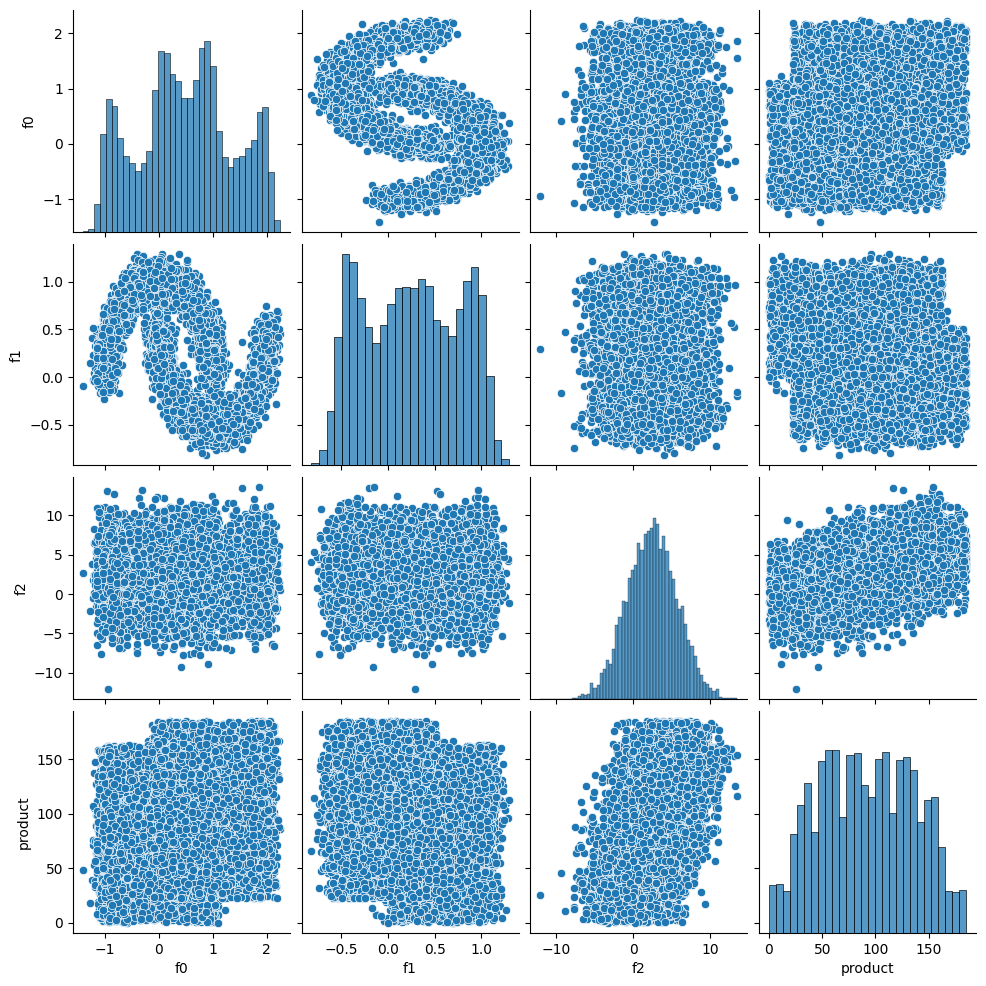

In [4]:
geo_data_0 = load_dataset('geo_data_0.csv')
general_info(geo_data_0)

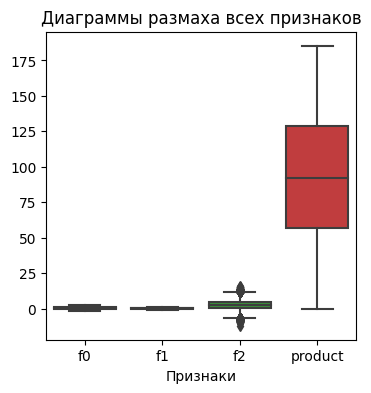

In [5]:
plt.figure(figsize=(4, 4))
ax = sns.boxplot(
    data=geo_data_0
)

ax.set_title('Диаграммы размаха всех признаков')
ax.set(xlabel='Признаки');

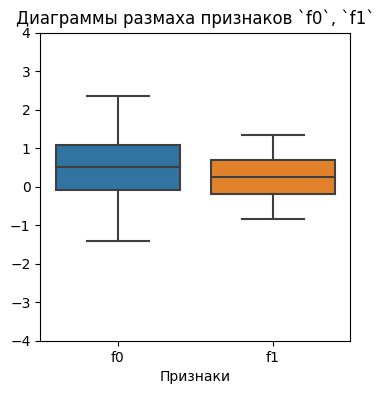

In [6]:
plt.figure(figsize=(4, 4))
plt.ylim(-4, 4)
ax = sns.boxplot(
    data=geo_data_0[['f0', 'f1']]
)

ax.set_title('Диаграммы размаха признаков `f0`, `f1`')
ax.set(xlabel='Признаки');

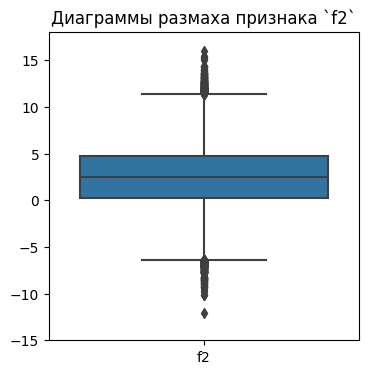

In [7]:
plt.figure(figsize=(4, 4))
plt.ylim(-15, 18)
ax = sns.boxplot(
    data=geo_data_0[['f2']]
)

ax.set_title('Диаграммы размаха признака `f2`');

__Заметки по общей информации для датасета `geo_data_0`__:
 - датасет состоит из 100000 объектов и 5 признаков, в том числе 1 целевой признак `product`;
 - признаки не содержат пропущенных значений;
 - признаки имеют соответствуюший тип данных;
 - датасет не содержит явных дубликатов (при сравнении по всем признаком);
 - коэффициенты корреляции признаков:
    - целевого признака `product` с:
       - `f0` 0.14
       - `f1` -0.19
       - `f2` 0.48
    - `f0` с `f1` -0.44: на диаграмме рассеивания зависимость заметна, но она нелинейная;
 - признак `f2` имеет нормальное распределение (по визуальной оценке по гистограмме).

#### Датасет `geo_data_1.csv`

Первые 5 строк датасета


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



Общая информация о признаках

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


Количество признаков, которые имеют пропущенные значения: 0

Доля признаков, которые имеют пропущенные значения 0.0


Количество явных дубликатов: 0


Описательные статистики признаков


,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,1.14,-4.80,2.49,68.83
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95



Коэффициенты корреляции признаков


,f0,f1,f2,product
f0,1.00,0.18,-0.00,-0.03
f1,0.18,1.00,-0.00,-0.01
f2,-0.00,-0.00,1.00,1.00
product,-0.03,-0.01,1.00,1.00



Гистограммы и парные диаграммы рассеивания


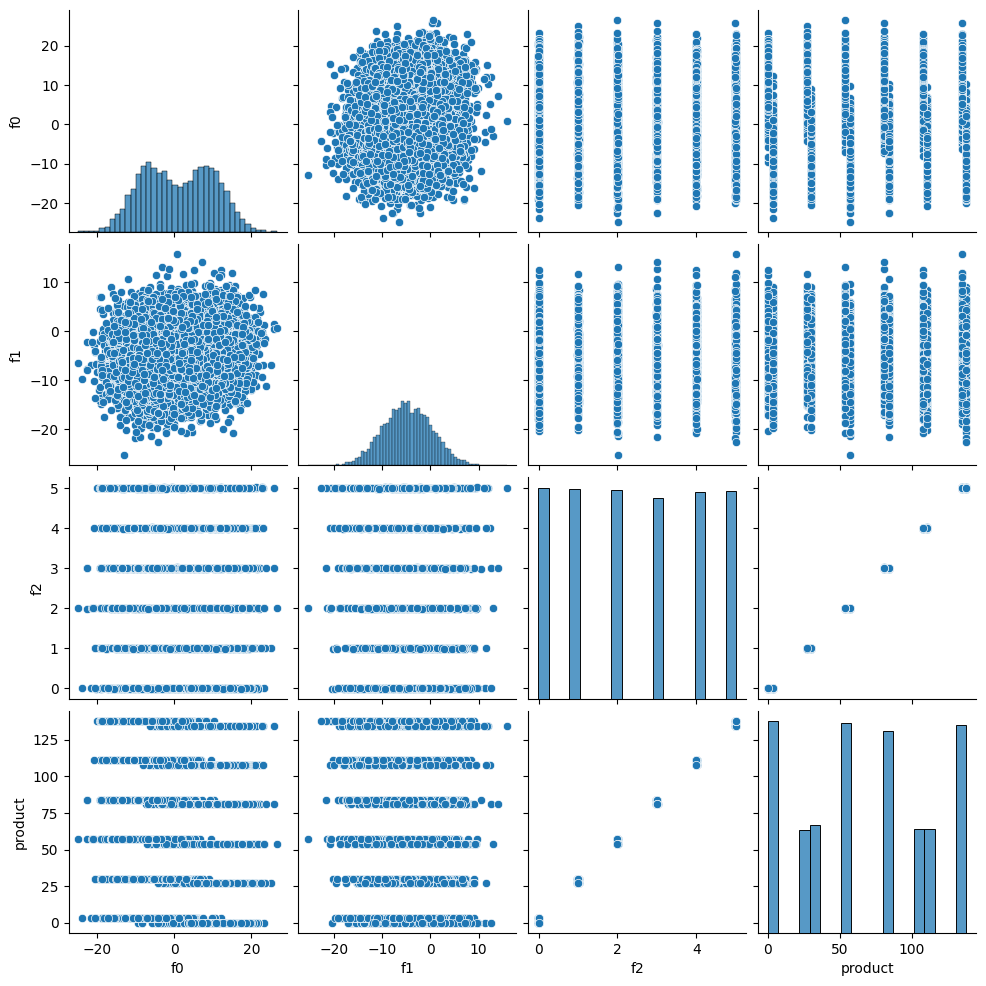

In [8]:
geo_data_1 = load_dataset('geo_data_1.csv')
general_info(geo_data_1)

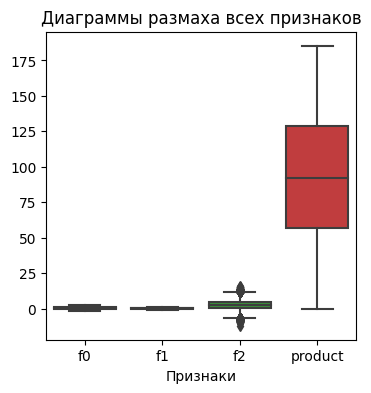

In [9]:
plt.figure(figsize=(4, 4))
ax = sns.boxplot(
    data=geo_data_0
)

ax.set_title('Диаграммы размаха всех признаков')
ax.set(xlabel='Признаки');

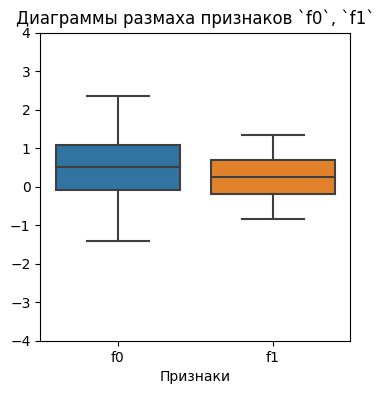

In [10]:
plt.figure(figsize=(4, 4))
plt.ylim(-4, 4)
ax = sns.boxplot(
    data=geo_data_0[['f0', 'f1']]
)

ax.set_title('Диаграммы размаха признаков `f0`, `f1`')
ax.set(xlabel='Признаки');

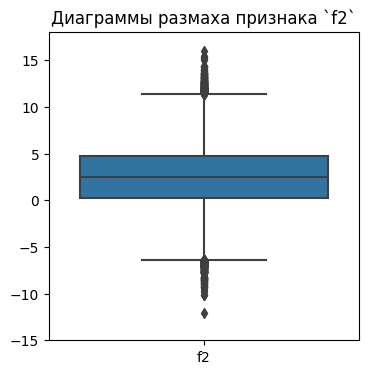

In [11]:
plt.figure(figsize=(4, 4))
plt.ylim(-15, 18)
ax = sns.boxplot(
    data=geo_data_0[['f2']]
)

ax.set_title('Диаграммы размаха признака `f2`');

__Заметки по общей информации для датасета `geo_data_1`__:
 - датасет состоит из 100000 объектов и 5 признаков, в том числе 1 целевой признак `product`;
 - признаки не содержат пропущенных значений;
 - признаки имеют соответствуюший тип данных;
 - датасет не содержит явных дубликатов (при сравнении по всем признаком);
 - коэффициенты корреляции признаков:
    - целевого признака `product` с:
       - `f0` -0.03
       - `f1` -0.01
       - `f2` 1.00 - __полная линейная зависимость__, что видно на диаграмме рассеивания

#### Датасет `geo_data_2.csv`

Первые 5 строк датасета


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



Общая информация о признаках

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


Количество признаков, которые имеют пропущенные значения: 0

Доля признаков, которые имеют пропущенные значения 0.0


Количество явных дубликатов: 0


Описательные статистики признаков


,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,0.00,-0.00,2.50,95.00
std,1.73,1.73,3.47,44.75
min,-8.76,-7.08,-11.97,0.00
25%,-1.16,-1.17,0.13,59.45
50%,0.01,-0.01,2.48,94.93
75%,1.16,1.16,4.86,130.60
max,7.24,7.84,16.74,190.03



Коэффициенты корреляции признаков


,f0,f1,f2,product
f0,1.00,0.00,-0.00,-0.00
f1,0.00,1.00,0.00,-0.00
f2,-0.00,0.00,1.00,0.45
product,-0.00,-0.00,0.45,1.00



Гистограммы и парные диаграммы рассеивания


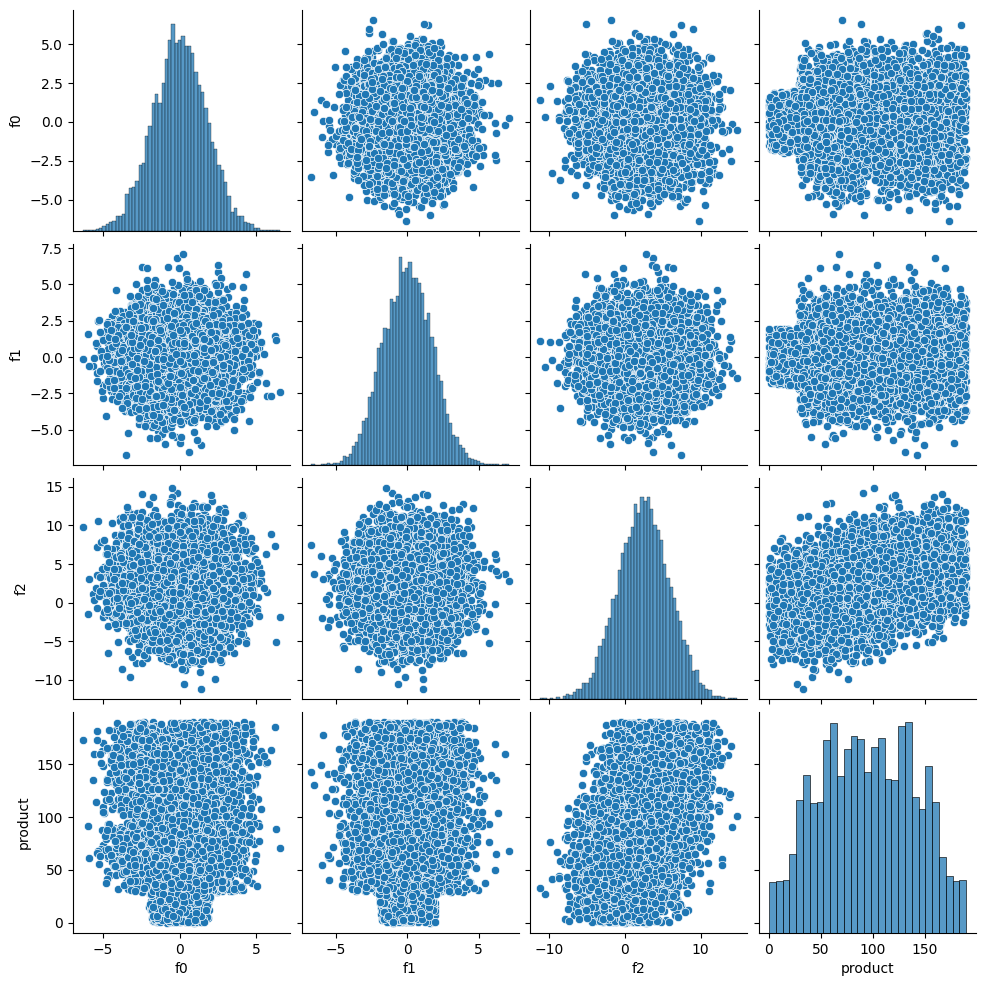

In [12]:
geo_data_2 = load_dataset('geo_data_2.csv')
general_info(geo_data_2)

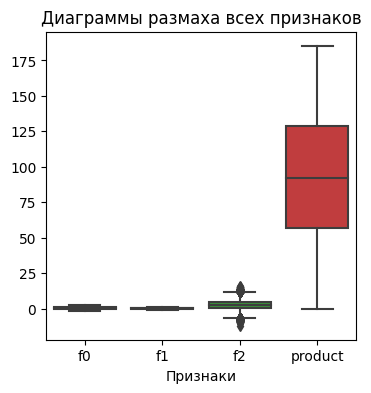

In [13]:
plt.figure(figsize=(4, 4))
ax = sns.boxplot(
    data=geo_data_0
)

ax.set_title('Диаграммы размаха всех признаков')
ax.set(xlabel='Признаки');

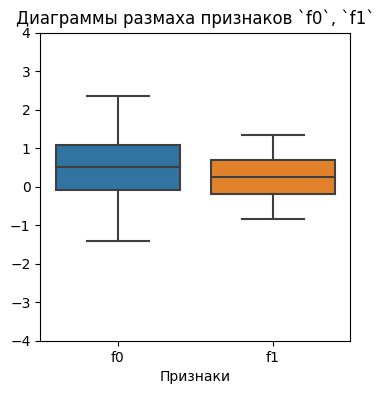

In [14]:
plt.figure(figsize=(4, 4))
plt.ylim(-4, 4)
ax = sns.boxplot(
    data=geo_data_0[['f0', 'f1']]
)

ax.set_title('Диаграммы размаха признаков `f0`, `f1`')
ax.set(xlabel='Признаки');

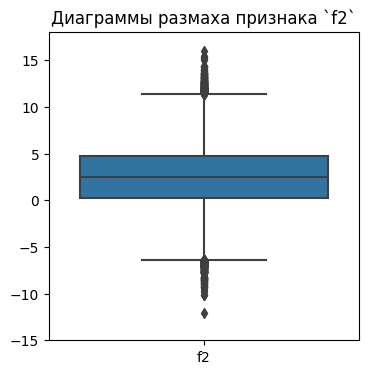

In [15]:
plt.figure(figsize=(4, 4))
plt.ylim(-15, 18)
ax = sns.boxplot(
    data=geo_data_0[['f2']]
)

ax.set_title('Диаграммы размаха признака `f2`');

__Заметки по общей информации для датасета `geo_data_2`__:
 - датасет состоит из 100000 объектов и 5 признаков, в том числе 1 целевой признак `product`;
 - признаки не содержат пропущенных значений;
 - признаки имеют соответствуюший тип данных;
 - датасет не содержит явных дубликатов (при сравнении по всем признаком);
 - коэффициенты корреляции признаков:
    - целевого признака `product` с:
       - `f0` 0.00
       - `f1` 0.00
       - `f2` 0.45
 - признаки `f0`, `f1`, `f2` имеют нормальное распределение (по визуальной оценке по гистограмме).

#### Вывод по общей информации по датасетам

 - каждый датасет состоит из 100000 объектов и 5 признаков, в том числе 1 целевой признак `product`;
 - признаки не содержат пропущенных значений;
 - признаки имеют соответствуюший тип данных;
 - датасет не содержит явных дубликатов (при сравнении по всем признаком);
 - __датасет `geo_data_0`__:
    - коэффициенты корреляции признаков:
        - целевого признака `product` с:
           - признаком `f0` 0.14
           - признаком `f1` -0.19
           - признаком `f2` 0.48
        - `f0` с `f1` -0.44: на диаграмме рассеивания зависимость заметна, но она нелинейная;
    - признак `f2` имеет нормальное распределение (по визуальной оценке по гистограмме).
 - __датасет `geo_data_1`__:
     - коэффициенты корреляции признаков:
        - целевого признака `product` с:
           - признаком `f0` -0.03
           - признаком `f1` -0.01
           - признаком `f2` 1.00 - __полная линейная зависимость__, что видно на диаграмме рассеивания
 - __датасет `geo_data_2`__:
     - коэффициенты корреляции признаков:
        - целевого признака `product` с:
           - признаком `f0` 0.00
           - признаком `f1` 0.00
           - признаком `f2` 0.45
     - признаки `f0`, `f1`, `f2` имеют нормальное распределение (по визуальной оценке по гистограмме).

### Подготовка данных

#### Проверка дубликатов в признаке `id`

##### Датасет `geo_data_0.csv`

In [16]:
geo_data_0.id.duplicated().sum()

10

In [17]:
geo_data_0.id.value_counts().head(12)

HZww2    2
TtcGQ    2
QcMuo    2
Tdehs    2
bxg6G    2
bsk9y    2
74z30    2
A5aEY    2
fiKDv    2
AGS9W    2
AiC4Z    1
qC8JG    1
Name: id, dtype: int64

In [18]:
geo_data_0[geo_data_0.id == 'Tdehs']

,id,f0,f1,f2,product
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
75715,Tdehs,0.112079,0.430296,3.218993,60.964018


##### Датасет `geo_data_1.csv`

In [19]:
geo_data_1.id.duplicated().sum()

4

In [20]:
geo_data_1.id.value_counts().head()

5ltQ6    2
wt4Uk    2
LHZR0    2
bfPNe    2
AjA6H    1
Name: id, dtype: int64

In [21]:
geo_data_1[geo_data_1.id == 'LHZR0']

,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625


##### Датасет `geo_data_2.csv`

In [22]:
geo_data_2.id.duplicated().sum()

4

In [23]:
geo_data_2.id.value_counts().head()

xCHr8    2
KUPhW    2
Vcm5J    2
VF7Jo    2
XwRhc    1
Name: id, dtype: int64

In [24]:
geo_data_2[geo_data_2.id == 'xCHr8']

,id,f0,f1,f2,product
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


##### Вывод по дубликатам в признаке `id`

В каждом датасете присутствуют дубликаты по признаку `id`, их не более 10 в каждом датасете. При этом эти объект имеют разные значения в других признках. Возможно это ошибка формирования значения id для объекта. Наличие таких дубликатов никак не навредит исследованию. Удалении их нецелесообразно.

#### Формирование словаря с датасетами

Для дальнейшего удобства работы с данными сформируем словарь из всех датасетов, где ключ - это название региона, значение - датасет по региону.

In [25]:
data_dict = {
    'geo_0': geo_data_0,
    'geo_1': geo_data_1,
    'geo_2': geo_data_2
}

In [26]:
REGIONS = list(data_dict.keys())
REGIONS

['geo_0', 'geo_1', 'geo_2']

#### Удаление неинформативного признака

Признак `id` является неинформативным для исследования, удалим его из датасетов.

In [27]:
for region in data_dict.keys():
    data_dict[region] = data_dict[region].drop(columns='id')

In [28]:
data_dict['geo_2'].head()

,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


#### Разделение данных на выборки

In [29]:
def log_shape_params(set_name, features, target, is_classification=True):
    print('Размер выборки:', set_name)
    print('\tfeatures:', features.shape)
    print('\ttarget:', target.shape)
    print()
    if is_classification:
        print('target value counts:')
        print(target.value_counts(1))
        print('\n')
    

def train_valid_test_split(df, target_name,
                           test_size=0.25,
                           is_valid_required=False,
                           valid_size=0.25,
                           is_classification=True,
                           logging=True):
    features = df.drop(columns=target_name)
    target = df[target_name]
    
    features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=test_size, random_state=RANDOM_STATE)
    
    if logging: log_shape_params('обучающая', features_train, target_train, is_classification)
    if logging: log_shape_params('тестовая', features_test, target_test, is_classification)
    
    if is_valid_required:
        features_train, features_valid, target_train, target_valid = train_test_split(
            features_train, target_train, test_size=valid_size, random_state=RANDOM_STATE)
        
        if logging: log_shape_params('валидационная', features_valid, target_valid, is_classification)
        
        return features_train, features_valid, features_test, target_train, target_valid, target_test
    
    return features_train, features_test, target_train, target_test

In [30]:
def pack_to_dict(train_valid_test_data, is_valid_required=False):
    df_dict = {}
    if is_valid_required:
        df_dict['features_train'] = train_valid_test_data[0]
        df_dict['features_valid'] = train_valid_test_data[1]
        df_dict['features_test'] = train_valid_test_data[2]
        df_dict['target_train'] = train_valid_test_data[3]
        df_dict['target_valid'] = train_valid_test_data[4]
        df_dict['target_test'] = train_valid_test_data[5]
        return df_dict
    df_dict['features_train'] = train_valid_test_data[0]
    df_dict['features_test'] = train_valid_test_data[1]
    df_dict['target_train'] = train_valid_test_data[2]
    df_dict['target_test'] = train_valid_test_data[3]
    return df_dict

Сформируем словарь с `train`, `test` выборками по регионам.<br>
Ниже представлена схема словаря:

In [31]:
splitted_data_schema = \
{
    'geo_0': {
        'features_train': '<pd.DataFrame>',
        'features_test': '<pd.DataFrame>',
        'target_train': '<pd.DataFrame>',
        'target_test': '<pd.DataFrame>'
    },
    'geo_1': {
        'features_train': '<pd.DataFrame>',
        'features_test': '<pd.DataFrame>',
        'target_train': '<pd.DataFrame>',
        'target_test': '<pd.DataFrame>'
    },
    'geo_2': {
        'features_train': '<pd.DataFrame>',
        'features_test': '<pd.DataFrame>',
        'target_train': '<pd.DataFrame>',
        'target_test': '<pd.DataFrame>'
    }
}

In [32]:
splitted_data = {}

is_valid_required = False

for region in data_dict.keys():
    splitted_data[region] = (
        pack_to_dict(
            train_valid_test_split(
                data_dict[region],
                target_name='product',
                test_size=0.25,
                is_valid_required=False,
                is_classification=False,
                logging=False
            ),
            is_valid_required=False
        )
    )

Посмотрим выборочно сожержание обной из выборок

In [33]:
splitted_data.keys()

dict_keys(['geo_0', 'geo_1', 'geo_2'])

In [34]:
splitted_data['geo_2']['features_train'].head()

,f0,f1,f2
92092,-0.236124,-1.090452,5.330730
1235,4.285671,-3.235728,3.249436
24409,1.490908,-0.071038,2.875002
38835,2.018609,0.042937,7.587216
52379,-0.858187,1.591417,2.686926


In [35]:
splitted_data['geo_2']['features_train'].shape

(75000, 3)

#### Масштабирование данных

В датасете остались только количественные признаки. Они имеют разный мастштаб. Нормализуем масштаб признаков с помощью скейлера `MinMaxScaler`

Для визуального контроля результатов масштабирования выведем информацию для одной из выборок до и после масштабирования.

In [36]:
splitted_data['geo_2']['features_test'].describe().round(2)

,f0,f1,f2
count,25000.00,25000.00,25000.00
mean,0.01,-0.00,2.51
std,1.74,1.74,3.50
min,-6.66,-7.08,-11.61
25%,-1.17,-1.18,0.11
50%,-0.00,-0.01,2.48
75%,1.17,1.18,4.89
max,7.22,7.76,16.74


In [37]:
splitted_data['geo_2']['target_train'].describe().round(2)

count    75000.00
mean        94.97
std         44.76
min          0.00
25%         59.39
50%         94.97
75%        130.57
max        190.03
Name: product, dtype: float64

In [38]:
split_names = ['train', 'test']
columns_to_scale = ['f0', 'f1', 'f2']

for region in splitted_data.keys():
    features_scaler = MinMaxScaler()
    features_scaler.fit(splitted_data[region]['features_train'][columns_to_scale])
    for split_name in split_names:
        features = splitted_data[region]['features_' + split_name]
        features[columns_to_scale] = features_scaler.transform(features[columns_to_scale])
        splitted_data[region]['features_' + split_name] = features

In [39]:
splitted_data['geo_2']['features_test'].describe().round(2)

,f0,f1,f2
count,25000.00,25000.00,25000.00
mean,0.55,0.46,0.51
std,0.11,0.12,0.12
min,0.13,-0.02,0.01
25%,0.47,0.38,0.43
50%,0.55,0.46,0.51
75%,0.62,0.54,0.60
max,1.00,0.99,1.01


In [40]:
splitted_data['geo_2']['target_train'].describe().round(2)

count    75000.00
mean        94.97
std         44.76
min          0.00
25%         59.39
50%         94.97
75%        130.57
max        190.03
Name: product, dtype: float64

## Обучение и проверка модели

Применим для исследования модель `sklearn.linear_model.LinearRegression`

In [41]:
prediction_results = pd.DataFrame(columns = ['init_index', 'target', 'prediction', 'region'])

for region in REGIONS:

    features_train = splitted_data[region]['features_train']
    target_train = splitted_data[region]['target_train']
    features_test = splitted_data[region]['features_test']
    target_test = splitted_data[region]['target_test']

    model = LinearRegression()
    model.fit(features_train, target_train)
    print(f'Regression coefficients for region \'{region}\':', model.coef_)
    predicted_test = model.predict(features_test)
    predicted_test = pd.Series(predicted_test, index=target_test.index)
    
    result_test = pd.concat([target_test, predicted_test], axis=1)
    result_test['region'] = region
    result_test.reset_index(inplace=True)
    result_test.columns = ['init_index', 'target', 'prediction', 'region']
    
    prediction_results = pd.concat([prediction_results, result_test])

prediction_results.reset_index(drop=True, inplace=True)

Regression coefficients for region 'geo_0': [ 13.73866059 -31.06959367 185.72496424]
Regression coefficients for region 'geo_1': [ -8.84782494  -0.98019705 135.77469403]
Regression coefficients for region 'geo_2': [ -1.15550363  -0.50717354 164.23203068]


Выведем общий сводный результат обучения и тестирования моделей по регионам

In [42]:
overall_results = pd.DataFrame(columns=['Регион', 'Средний прогнозируемый запас сырья', 'RMSE на тесте', 'R2'])

for region in REGIONS:
    target = prediction_results[prediction_results.region == region].target
    prediction = prediction_results[prediction_results.region == region].prediction

    region_overall_results = {
        'Регион': region,
        'Средний прогнозируемый запас сырья': prediction.mean(),
        'RMSE на тесте': mean_squared_error(target, prediction, squared=False),
        'R2': r2_score(target, prediction)
    } 
    
    overall_results = overall_results.append(region_overall_results, ignore_index=True)
    
overall_results.round(3)

,Регион,Средний прогнозируемый запас сырья,RMSE на тесте,R2
0,geo_0,92.544,37.716,0.272
1,geo_1,68.865,0.888,1.000
2,geo_2,95.095,40.241,0.191


__Выводы:__
 - максимальный средний прогнозируемый запас сырья имеет регион `geo_2`, при этом модель для этого региона имеет максимальное значение RMSE на тесте из всех моделей, и минимальное значние R2 метрики;
 - максимальный средний прогнозируемый запас сырья имеет регион `geo_1`, при этом метрика R2 равна 1, что объясняется прямой зависимостью целевого признакак от признака `f2`.

## Подготовка к расчёту прибыли

Бюджет на разработку скважин в регионе — 10 млрд рублей.

In [43]:
REGION_WELLS_DEVELOPMENT_BUDGET = 10e9
REGION_WELLS_DEVELOPMENT_BUDGET

10000000000.0

При разведке региона исследуют 500 точек под скважины, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

In [44]:
WELLS_NUMBER_FOR_RESEARCHING = 500
WELLS_NUMBER_FOR_RESEARCHING

500

In [45]:
TOP_WELLS_NUMBER = 200
TOP_WELLS_NUMBER

200

Рассчитаем бюджет на разработку одной скважины:

In [46]:
ONE_WELL_DEVELOPMENT_BUDGET = REGION_WELLS_DEVELOPMENT_BUDGET / TOP_WELLS_NUMBER
ONE_WELL_DEVELOPMENT_BUDGET

50000000.0

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

In [47]:
REVENUE_FROM_BARREL = 450
REVENUE_FROM_BARREL

450

In [48]:
REVENUE_FROM_ONE_UNIT_OF_PRODUCT = 1000 * REVENUE_FROM_BARREL
REVENUE_FROM_ONE_UNIT_OF_PRODUCT

450000

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины:

In [49]:
SUFFICIENT_RESERVES_VOLUME = ONE_WELL_DEVELOPMENT_BUDGET / REVENUE_FROM_ONE_UNIT_OF_PRODUCT

print('Достаточный объём сырья для безубыточной разработки новой скважины составляет'
      + f' {SUFFICIENT_RESERVES_VOLUME:.4f} единиц продукта')

Достаточный объём сырья для безубыточной разработки новой скважины составляет 111.1111 единиц продукта


Сравним полученный объём сырья со средним (прогнозируемым) запасом в каждом регионе:

In [50]:
overall_results.round(3)

,Регион,Средний прогнозируемый запас сырья,RMSE на тесте,R2
0,geo_0,92.544,37.716,0.272
1,geo_1,68.865,0.888,1.000
2,geo_2,95.095,40.241,0.191


Видно, что достаточный объём сырья для безубыточной разработки новой скважины заметно больше, чем средний (прогнозируемый) запас в каждом регионе.<br>
При этом стоит отметить, что при расчёте среднего запаса средняя ошибка составила значительную долю от самого среднего запаса для 2-х из 3-х регионов

In [51]:
(overall_results['RMSE на тесте'] / overall_results['Средний прогнозируемый запас сырья']).round(3)

0    0.408
1    0.013
2    0.423
dtype: float64

__Вывод:__
 - Таким образом, если среди выбранных для разработки скважин окажутся скважины с запасом равным среднему (прогнозируемому) запасу, то эти скважины наиболее вероятно окажутся убыточными.

## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по скважинам с максимальными значениями предсказаний в регионе

In [54]:
def calculate_income(prediction_results: pd.core.frame.DataFrame,
                      top_wells_number: int,
                      revenue_from_one_unit_of_product: int):
    """
    Функция расчёта прибыли по выбранным лучшим скважинам.
    """
    reserves_volume = (
        prediction_results
        .sort_values('prediction', ascending=False)
        .head(top_wells_number)['target']
        .sum()
    )
    income = (
        reserves_volume * revenue_from_one_unit_of_product
        - REGION_WELLS_DEVELOPMENT_BUDGET
    )
    return income

Расчитаем прибыль для каждого региона:

In [57]:
regions_income = {}
for region in REGIONS:
    regions_income[region] = calculate_income(
        prediction_results[prediction_results.region == region],
        TOP_WELLS_NUMBER,
        REVENUE_FROM_ONE_UNIT_OF_PRODUCT
    )

In [58]:
print(f'Прибыль (млрд. рублей) от суммарного объёма сырья для {TOP_WELLS_NUMBER} скважин\n'
      + ' с максимальными значениями продукта в регионах:')
for region, income in regions_income.items():
    print('\t', region, ':\t', (income/1e9).round(3))

Прибыль (млрд. рублей) от суммарного объёма сырья для 200 скважин
 с максимальными значениями продукта в регионах:
	 geo_0 :	 3.197
	 geo_1 :	 2.415
	 geo_2 :	 2.638


Рассчитаем среднюю прибыль, 95%-й доверительный интервал и риск убытков для каждого региона с помощью техники Bootstrap с 1000 выбороками.

In [59]:
CONFIDENCE_INTERVAL_AS_PERCENTAGE = 95

lower_quantile = (100 - CONFIDENCE_INTERVAL_AS_PERCENTAGE) / 2
upper_quantile = 100 - (100 - CONFIDENCE_INTERVAL_AS_PERCENTAGE) / 2

BOOTSTRAP_SUBSAMPLES_NUMBER = 1000

In [61]:
report_columns = [
    'Регион',
    'Средняя прибыль (оборот), млн. руб.',
    'Нижняя граница 95% доверительного интервала, млн. руб.',
    'Верхняя граница 95% доверительного интервала, млн. руб.',
    'Риск (вероятность) убытков, %'
]
report = pd.DataFrame(columns=report_columns)

for region in REGIONS:
    region_prediction_results = prediction_results[prediction_results.region == region]

    state = np.random.RandomState(RANDOM_STATE)
    average_income = []
    
    for i in range(BOOTSTRAP_SUBSAMPLES_NUMBER):
        region_product_subsample = (
            region_prediction_results
            .sample(n=WELLS_NUMBER_FOR_RESEARCHING, replace=True, random_state=state)
        )
        
        region_income = calculate_income(
            region_product_subsample,
            TOP_WELLS_NUMBER,
            REVENUE_FROM_ONE_UNIT_OF_PRODUCT
        )
        
        average_income.append(region_income)

    average_income = pd.Series(average_income)
    
    lower = average_income.quantile(q=lower_quantile/100)
    upper = average_income.quantile(q=upper_quantile/100)
    
    loss_probability = stats.percentileofscore(average_income, 0)
    
    region_report = [region, average_income.mean()/1e6, lower/1e6, upper/1e6, loss_probability]
    report.loc[len(report)] = region_report

### Вывод по исследованию

По результатам исследованияя установлено что:
 - только регион `geo_1` имеет риск убытков менее 2.5%, и он составлет 1%:
 - регионы `geo_0` и `geo_2` имеют риск убытков 8.6% и 7.7% соответственно;
 - максимальную среднюю прибыль в 455.7 млн. рублей имеет регион `geo_1`.